# Curso de Big Data

## Trabajo Practico 1 - Parte 2
## Análisis de sentimiento de tweets de Joe Biden, pre y post elecciones

In [2]:
# Se importan los paquetes a utilizar.

import os
import re
import string
from datetime import timezone as tz
from datetime import datetime 

import pandas as pd
import tweepy
from textblob import TextBlob
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Lo primero que hago es crear un botón que permita esconder todas las celdas que sean código y mostrar todo lo demás si se lo desea. La solución no es original, sino que se obtuvo de una provista por el usuario de Stack Overflow Eric Shepherd en el siguiente link: https://stackoverflow.com/a/53136940

In [24]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

También se suma el siguiente código para ocultar las warnings, entendiendo que las mismas son útiles pero molestas en el caso de una presentación cuando ya se entendió el motivo de las mismas. Por este motivo, también se deja comentada una línea que permite limitar la cantidad de advertencias por acción a 1. 

In [26]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [3]:
# Se crean variables que contienen las claves de autenticación en la API de Twitter. 

# Por razones de seguridad, este archivo no se encuentra subido a GitHub. Sin embargo, esto no obstaculiza la posibilidad de ver el output del código.

with open("twitter_keys.txt") as tw_k: 
    consumer_key = tw_k.readline().strip()
    consumer_secret = tw_k.readline().strip()
    access_key = tw_k.readline().strip()
    access_secret = tw_k.readline().strip()

In [4]:
# Tweepy recibe las credenciales de Twitter.

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [6]:
def get_all_tweets(screen_name, start_date):
    '''
    Esta funcion recibe el nombre de la persona de quien queremos extraer los 
    tweets y devuelve una lista con todos los tweets y sus datos
    Input: 
      screen_name (str): el nombre de la persona en twitter
      start_date(datetime): fecha desde la que se quieren los tweets
    Output:
      all_tweets (lista): lista con todos los tweets extraidos
    '''
    # Solicitamos los 200 tweets mas recientes (200 es el maximo permitido en count)
    new_tweets = api.user_timeline(screen_name=screen_name, 
                                   tweet_mode="extended", count=200)
    # Creo una lista vacía para almacenar TODOS los tweets y agrego los recién extraidos (con el método extend)
    all_tweets = []
    all_tweets.extend(new_tweets)
    # guardo el id del ultimo tweet extraído (los id son numéricos y van creciendo en el tiempo, por eso en el loop pedimos que traiga los de id mayor)
    oldest = all_tweets[-1].id 
    
    # Extraigo tweets de a 200 hasta que no haya más: le damos 2 puntos para cortar...
    # ...el segundo es que siga mientras la fecha del último tweet añadido sea mayor a la que indicamos como start_date, el primero nos dice que en la última consulta haya encontrado algo.
    # Algo clave es que el loop funciona desde lo más nuevo y ahí va para atrás: por eso en max_id decimos "-1": queremos que siga con la id inmediatamente interior al último tweet añadido.
    while len(new_tweets) > 0 and all_tweets[-1].created_at > start_date:
        # Solicito 200 tweets mas y los agrego a la lista de 'all_tweets'
        new_tweets = api.user_timeline(screen_name=screen_name, count=200,
                                       tweet_mode="extended", max_id=oldest-1)
        all_tweets.extend(new_tweets)
        # actualizo el id del ultimo tweet extraído (indico con el -1 que nos consiga el id del último tweet añadido en all_tweets)
        oldest = all_tweets[-1].id 
        print("Hasta ahora se han extraído %s tweets." % len(all_tweets))

    return all_tweets

In [7]:
# Se extran los tweets desde unos días antes de las elecciones del 3 de Noviembre de 2020

date_before_elections = datetime(2020, 10, 16, 0, 0, 0, tzinfo=tz.utc) # los 0 son la hora
all_tweets_biden = get_all_tweets("JoeBiden", date_before_elections) # nombre y fecha, los argumentos para la función definida

Hasta ahora se han extraído 400 tweets.
Hasta ahora se han extraído 600 tweets.
Hasta ahora se han extraído 800 tweets.
Hasta ahora se han extraído 1000 tweets.
Hasta ahora se han extraído 1200 tweets.
Hasta ahora se han extraído 1400 tweets.
Hasta ahora se han extraído 1600 tweets.
Hasta ahora se han extraído 1800 tweets.
Hasta ahora se han extraído 2000 tweets.
Hasta ahora se han extraído 2199 tweets.
Hasta ahora se han extraído 2399 tweets.
Hasta ahora se han extraído 2599 tweets.


In [8]:
def save_tweets_text(all_tweets, csv_file=None):
    '''
    Esta función guarda los tweets en un data frame y si se especifica un 
    archivo csv tambien se guardaran ahí 
    Input:
        all_tweets (lista): lista con tweets y sus datos
        csv_file ('str'): nombre del archivo csv
    Output:
        df_all_tweets (df): tweets ordenados en una tabla con datos seleccinados
    '''
    all_tweets_selection = [] # Lista vacía, es algo que hacemos antes de la iteración de la que queremos guardar resultados
    for tweet in all_tweets:
        one_tweet = [tweet.id_str, tweet.created_at, tweet.full_text, 
                     tweet.retweeted, tweet.favorite_count, 
                     tweet.in_reply_to_screen_name]
        all_tweets_selection.append(one_tweet) 
# Con el append guardamos listas como elemento dentro de la lista. Expand era para sumar la lista al final de la que ya estaba.
    
    df_all_tweets = pd.DataFrame(all_tweets_selection) # Cada lista se transforma en una fila
    df_all_tweets.columns = ['id_str', 'created_at', 'text', 'retweeted',
                            'favorite_count', 'in_reply_to_screen_name'] # Acá le damos una lista con el nombre de las columnas
    if csv_file: # Este if evalúa si hay algo en csv_file (el default era none, vacío)
        df_all_tweets.to_csv(csv_file, index=False, encoding="utf-8")

    return df_all_tweets

In [10]:
# Se arma el dataframe con todos los tweets de Joe Biden, viéndose el ejemplo de como queda abajo.

df_all_tweets = save_tweets_text(all_tweets_biden, "tweets.csv")
df_all_tweets

,id_str,created_at,text,retweeted,favorite_count,in_reply_to_screen_name
0,1609580712289525760,2023-01-01 16:02:01+00:00,"Happy New Year, folks. \n\nI'm more optimistic...",False,27532,None
1,1609321020476821506,2022-12-31 22:50:05+00:00,"We’ve got more work to do, but this year, we s...",False,20649,None
2,1608976478963736576,2022-12-31 00:01:00+00:00,"Starting January 1, seniors on Medicare can’t ...",False,37119,None
3,1608873646222708737,2022-12-30 17:12:23+00:00,A few great moments from a historic year.\n\nI...,False,13499,None
4,1608600378429394946,2022-12-29 23:06:31+00:00,Reflecting on one of my favorite moments from ...,False,46326,None
...,...,...,...,...,...,...
2594,1316487694818500608,2020-10-14 21:15:00+00:00,Rhode Island and Tennessee — early voting has ...,False,12026,None
2595,1316478131788746756,2020-10-14 20:37:00+00:00,Don't throw away your shot to spend Friday nig...,False,13741,None
2596,1316463787579502596,2020-10-14 19:40:00+00:00,Today would have been George Floyd’s 47th birt...,False,175809,None
2597,1316446172521795584,2020-10-14 18:30:00+00:00,"Tonight, our campaign will close our books and...",False,9068,None


In [11]:
# Emoticons contentos
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Emoticons Tristes
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [12]:
#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # simbolos & pictogramas
                           u"\U0001F680-\U0001F6FF"  # transporte & simbolos mapas
                           u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

In [13]:
def clean_tweets(tweet):
    '''
    Esta función limpia el texto del tweet. Elimina emoticones, palabras vacías,
    links, indicaciones de retweets, etc. Para dejar en el texto solo las
    palabras con mayor contenido.
    Input:
        tweet (str): Texto del tweet original
    Output:
        tweet (str): Texto del tweet limpiado
    '''
    # Paquete re es el de regular expressions, la función sub hace un substring (extrae lo que coincida con el patrón)
    # y lo reemplaza por lo que le indicamos (vacío en este caso), y que entonces nos dé el tweet original con el cambio.
    
    #Elimino caracteres de re-tweets   
    tweet = re.sub(r'^RT .*:', '', tweet)
    tweet = re.sub(r'@\S+', '', tweet)
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #Reemplazo caracteres non-ASCII con espacio
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #Saco los links
    tweet = re.sub(r'https.*', '', tweet)
    #Saco los emoji
    tweet = emoji_pattern.sub(r'', tweet)
    
    #Separo los tweets in tokens
    word_tokens = word_tokenize(tweet) # Esta es una función que a un string lo parte en tokens (palabras por separado).
    #Obtengo set de palabras vacias para luego eliminarlas
    stop_words = set(stopwords.words('english')) # Estas stop words son palabras que no dicen nada (las que conectan por ejemplo)
    
    #loop por las condiciones
    filtered_tweet = [] # Creamos lista vacía para las palabras que queremos conservar
    for w in word_tokens: # El tweet ya está separado en palabras sueltas
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and \
           w not in string.punctuation:
            filtered_tweet.append(w) # Si no cumple ninguna de las condiciones, la sumo a la lista.

    
    return ' '.join(filtered_tweet) 
# Nos devuelve nuevamente un tweet, pero habiéndole filtrado cosas.
# El join las une con un espacio entre ellas (las palabras)

In [14]:
#Ejemplo de un tweet sucio:
df_all_tweets.iloc[0]['text']

"Happy New Year, folks. \n\nI'm more optimistic about America's future than I've ever been."

In [15]:
#Ejemplo de un tweet limpio:
clean_tweets(df_all_tweets.iloc[0]['text'])

"Happy New Year folks I 'm optimistic America 's future I 've ever"

In [16]:
def filter_year_and_month(date_tweet, start_time, end_time):
    '''
    Recibe una fecha y devuelve True, si la fecha de la fila esta 
    dentro de los dias especificados como inicio y fin, caso 
    contrario False.
    '''
    dd = pd.to_datetime(date_tweet).date()
    return dd > start_time and dd < end_time
 

In [19]:
def generate_sentiment(texto):
    '''
    Esta funcion limpia el texto y analiza el sentimiento.
    Input:
        texto (str): texto a limpiar y analizar
    Output:
         polarity (float): en el rango [-1.0, 1.0] 
         subjectivity (float): en el rango [0.0, 1.0] 
    '''
    # Se limpia el texto del tweet
    filtered_tweet = clean_tweets(texto)
    # Se calcula el sentimiento con el metodo TextBlob
    blob = TextBlob(filtered_tweet)
    Sentiment = blob.sentiment # El sentiment se define por su polarity y subjectivity, definidos como están abajo.

    polarity = Sentiment.polarity
    subjectivity = Sentiment.subjectivity            

    return polarity, subjectivity
    

Polarity: Negative (-1.0) vs. Positive (1.0)

Subjectivity: Objective (0.0) vs. Subjective (1.0)

In [20]:
def add_sentiment(df, start_time, end_time):
    '''
    Esta funcion filtra los tweets entre las fechas de inicio y fin
    indicadas y agrega dos columnas, una de polarity y otra de subjectivity.
    Input:
        df (dataframe): tabla con los tweets en una columa llamada text
        start_time (datetime): fecha del tweet más antiguo a conservar
        end_time (datetime): fecha del tweet más reciente a conservar
    Output:
        df (dataframe): df actualizado con el filtro y nuevas columnas
    '''
    df = df[df.apply(lambda row: filter_year_and_month(row['created_at'], 
                                                start_time, end_time), axis=1)]
# Se pide que agregue dos columnas nuevas y las llene con lo que da generate_sentiment
    df[["polarity", "subjectivity"]] = pd.DataFrame(df.apply(lambda row: \
                                            generate_sentiment(row['text']), \
                                            axis=1).tolist(), index=df.index)
    
    return df

In [22]:
# Se construyen las variables para la fecha inicial y la fecha final.
start_time = datetime.strptime("2020-10-20", '%Y-%m-%d').date()
end_time = datetime.strptime("2020-11-18", '%Y-%m-%d').date()

In [28]:
# Se muestra el nivel de polarización y subjetividad de los diferentes tweets.

tweets_sentimiento = add_sentiment(df_all_tweets, start_time, end_time)
tweets_sentimiento

,id_str,created_at,text,retweeted,favorite_count,in_reply_to_screen_name,polarity,subjectivity
1990,1328837822950752259,2020-11-17 23:10:00+00:00,"Today, @KamalaHarris and I met with some of ou...",False,107196,None,0.500000,0.700000
1991,1328790008963227649,2020-11-17 20:00:00+00:00,I’m keeping in my prayers all of our friends a...,False,245743,None,0.266667,0.583333
1992,1328734005404061701,2020-11-17 16:17:28+00:00,RT @Transition46: Our White House senior staff...,False,0,None,0.000000,0.000000
1993,1328474177007972354,2020-11-16 23:05:00+00:00,Americans want us to cooperate. They want us t...,False,122258,None,0.500000,0.812500
1994,1328467885279375361,2020-11-16 22:40:00+00:00,"When we build back better, we will do so with ...",False,179988,None,0.250000,0.285714
...,...,...,...,...,...,...,...,...
2479,1318937589097717760,2020-10-21 15:30:00+00:00,Justice is on the ballot.\n\nhttps://t.co/eoxT...,False,21675,None,0.000000,0.000000
2480,1318919971653578752,2020-10-21 14:20:00+00:00,West Virginia — in-person early voting is now ...,False,16371,None,0.050000,0.400000
2481,1318915442153562115,2020-10-21 14:02:00+00:00,Missouri — today is the last day to request a ...,False,13125,None,0.000000,0.066667
2482,1318753877076881408,2020-10-21 03:20:00+00:00,It’s time we see each other as fellow American...,False,101824,None,0.318182,0.550000


#### Ejercicio 1: 
Impriman algunos de los tweets más negativos (filtrando por la columna de `polarity`) y su fecha

In [30]:
tweets_negativos = tweets_sentimiento[['created_at', 'text', 'polarity']].sort_values("polarity") #con esta línea se define un nuevo dataframe compuesto por tres columnas del original. La función .sort_values permite ordenar el nuevo dataframe en orden ascendente según el nivel de polarización.

# Se genera una nueva columna llamada "fecha" donde solo se separan el año, mes y día de cada tweet. 
tweets_negativos["fecha"] = tweets_negativos["created_at"].astype(str).str.slice(0,10)

tweets_negativos_head = tweets_negativos.head()

# Se crea una lista con números del 0 al 4 por la cantidad de tweets en el dataframe creado en el paso anterior.
mi_lista = [0,1,2,3,4]

# Se arma un loop para que imprima únicamente las columnas de fecha y texto de cada uno de los cinco tweets más negativos.

for i in mi_lista:
    print("El día", tweets_negativos_head.iloc[i]['fecha'], "Joe Biden twitteó:",tweets_negativos_head.iloc[i]['text'])

El día 2020-11-03 Joe Biden twitteó: After tonight's horrific terrorist attack in Vienna, Austria, Jill and I are keeping the victims and their families in our prayers. We must all stand united against hate and violence.
El día 2020-11-11 Joe Biden twitteó: If you’re sick, if you’re struggling, if you’re worried about how you’re going to get through the day — we will not abandon you.

We will not leave you to face these challenges alone. https://t.co/eZUHaFE5bl
El día 2020-11-13 Joe Biden twitteó: Today marks five years since the horrific ISIS terrorist attacks in Paris — an assault not just on the people of France but against our common humanity.

As president, I will work to protect Americans and our allies, countering terrorism and extremist violence in all forms.
El día 2020-11-01 Joe Biden twitteó: The hard truth is that under President Trump, we’ve become weaker, sicker, poorer, more divided, and more violent.
El día 2020-10-23 Joe Biden twitteó: He’s a confused guy. He doesn’t k

#### Ejercicio 2: 
Impriman algunos de los tweets más positivos (filtrando por la columna de `polarity`) y su fecha

In [31]:
# En este ejercicio se repite el procedimiento anterior, pero de forma inversa, buscando los cinco tweets más positivos.

tweets_positivos = tweets_sentimiento[['created_at', 'text', 'polarity']].sort_values("polarity", ascending=False)
tweets_positivos["fecha"] = tweets_positivos["created_at"].astype(str).str.slice(0,10)
tweets_positivos_head = tweets_positivos.head()
for i in mi_lista:
    print("El día", tweets_positivos_head.iloc[i]['fecha'], "Joe Biden twitteó:",tweets_positivos_head.iloc[i]['text'])

El día 2020-10-29 Joe Biden twitteó: Christen — tell your grandmother I’m incredibly grateful to have her support, and thank you for helping her cast her ballot. https://t.co/zRKbAPvqgF
El día 2020-11-16 Joe Biden twitteó: Once again, I congratulate the brilliant women and men who produced this breakthrough and have brought us one step closer to beating this virus. I am also thankful for the frontline workers who are still confronting the virus around the clock.
El día 2020-11-08 Joe Biden twitteó: Now that the campaign is over—what is the people’s will? What is our mandate?

I believe it is this: Americans have called on us to marshal the forces of decency and the forces of fairness. To marshal the forces of science and the forces of hope in the great battles of our time.
El día 2020-11-04 Joe Biden twitteó: Keep the faith, guys. We’re gonna win this.
El día 2020-11-02 Joe Biden twitteó: 1 day. Let’s win this thing.


###### Ejercicio 3: 
Agreguenle al df llamado `tweets_sentimiento` una nueva columna llamada `positivo` que tenga:
- 1 cuando el tweet tiene polarity > 0, 
- 0 cuando el tweet tiene polarity = 0, 
- -1 cuando el tweet tiene polarity < 0 

In [32]:
# Ahora se agrega una nueva columna al dataframe original, definida usando una función lambda que permite de forma sencilla resumir las sentencias que determinan los valores con los que se llenará la nueva columna

tweets_sentimiento["positivo"] = tweets_sentimiento["polarity"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
tweets_sentimiento

,id_str,created_at,text,retweeted,favorite_count,in_reply_to_screen_name,polarity,subjectivity,positivo
1990,1328837822950752259,2020-11-17 23:10:00+00:00,"Today, @KamalaHarris and I met with some of ou...",False,107196,None,0.500000,0.700000,1
1991,1328790008963227649,2020-11-17 20:00:00+00:00,I’m keeping in my prayers all of our friends a...,False,245743,None,0.266667,0.583333,1
1992,1328734005404061701,2020-11-17 16:17:28+00:00,RT @Transition46: Our White House senior staff...,False,0,None,0.000000,0.000000,0
1993,1328474177007972354,2020-11-16 23:05:00+00:00,Americans want us to cooperate. They want us t...,False,122258,None,0.500000,0.812500,1
1994,1328467885279375361,2020-11-16 22:40:00+00:00,"When we build back better, we will do so with ...",False,179988,None,0.250000,0.285714,1
...,...,...,...,...,...,...,...,...,...
2479,1318937589097717760,2020-10-21 15:30:00+00:00,Justice is on the ballot.\n\nhttps://t.co/eoxT...,False,21675,None,0.000000,0.000000,0
2480,1318919971653578752,2020-10-21 14:20:00+00:00,West Virginia — in-person early voting is now ...,False,16371,None,0.050000,0.400000,1
2481,1318915442153562115,2020-10-21 14:02:00+00:00,Missouri — today is the last day to request a ...,False,13125,None,0.000000,0.066667,0
2482,1318753877076881408,2020-10-21 03:20:00+00:00,It’s time we see each other as fellow American...,False,101824,None,0.318182,0.550000,1


#### Ejercicio 4: 
Agrupen los tweets por día y promedien la polaridad. Luego hagan un gráfico con el sentimiento por día.

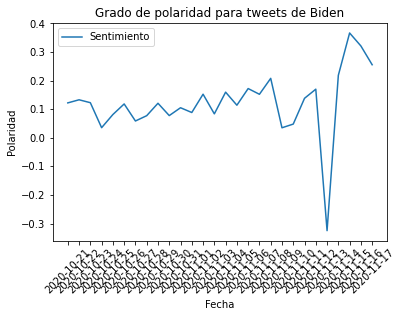

In [33]:
# Se importa el módulo pyplot del paquete matplotlib.
import matplotlib.pyplot as plt

# Se genera una nueva columna llamada "fecha" donde solo se separan el año, mes y día de cada tweet. 
tweets_sentimiento["fecha"] = tweets_sentimiento["created_at"].astype(str).str.slice(0,10) 

# Se realiza un group-by para agrupar las observaciones por su fecha, generando un promedio de la variable polarity para cada día.
tweets_sentimiento_group = tweets_sentimiento.groupby("fecha").agg({"polarity":"mean"})

# Se resetean las ID en el nuevo df, ya que cambió la cantidad de filas.
tweets_sentimiento_group.reset_index(inplace=True)

# Se definen las variables para el eje X (fecha) y para el eje Y (polarización).
x = tweets_sentimiento_group["fecha"]
y = tweets_sentimiento_group["polarity"]

# Se define  el objeto que va a almacenar nuestro gráfico.
fig = plt.plot(x, y, label="Sentimiento")

plt.xlabel("Fecha") # Se cambia la leyenda del eje X.
plt.ylabel("Polaridad") # Se cambia la leyenda del eje Y.
plt.title("Grado de polaridad para tweets de Biden") # Título del gráfico.
plt.xticks(rotation =45) # Se rotan las fechas del eje X para que no se solapen tanto.

plt.legend() # Se pide que se muestre la leyenda del gráfico.
plt.show(fig) # Se muestra el gráfico.

#### Repaso del análisis de sentimiento: 
Por último, los invito a que exploren el análisis de sentimiento de forma teórica y práctica:
- Revisen la documentación de `TextBlob` y del método `sentiment` https://textblob.readthedocs.io/en/dev/ 
- Prueben en la practica el resultado que arroja para determinadas frases (les dejo unos ejemplos, pero pueden probar los que quieran)


In [34]:
blob_1 = TextBlob('My grandma can do a better job than Joe Biden!')
blob_1.sentiment # esta función interpreta que la frase tiene una connotación positiva, contrario a lo que un humano esperaría.

Sentiment(polarity=0.625, subjectivity=0.5)

In [35]:
blob_2 = TextBlob('Biden election was a fraud!')
blob_2.sentiment # nuevamente, el comando devuelve resultados que no son los que interpretaría una persona, tanto en subjetividad como polarización.

Sentiment(polarity=0.0, subjectivity=0.0)

In [37]:
# Se define una lista con frases para el análisis de sentimiento

frases = TextBlob("Today was a beautiful day. "
               "I came home from work and took my dog to the park. "
               "Then I saw a picture of Joe Biden. "
                "And everything was ruined. ")

# Se crea un loop para que impriman los niveles de polarización y subjetividad de cada elemento de la lista, a partir del comando .sentences:

for frase in frases.sentences:
    print("El grado de polarización de la frase", frase, "es de", frase.sentiment.polarity, "mientras que su subjetividad es del", frase.sentiment.subjectivity)

El grado de polarización de la frase Today was a beautiful day. es de 0.85 mientras que su subjetividad es del 1.0
El grado de polarización de la frase I came home from work and took my dog to the park. es de 0.0 mientras que su subjetividad es del 0.0
El grado de polarización de la frase Then I saw a picture of Joe Biden. es de 0.0 mientras que su subjetividad es del 0.0
El grado de polarización de la frase And everything was ruined. es de 0.0 mientras que su subjetividad es del 0.0
